Import required Python modules

In [2]:
# !/usr/bin/env python.
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Import functions from the OPENSENSE sandbox

In [3]:
import PWSpyqcFunctions as pyqc
import pycomlink as pycml

# Link to the data
#main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"
#change back to online source once everything is finished
main_dir = r"/home/jose/Nextcloud/OPENSENSE/2023_06_Krakow/Sandbox/pws-pyqc/OpenSense/Data/"


## General Information

This Notebook demontrates the PWSpy-QC algorithm with was developed to filter and bias correct data from Netamo personal weather stations (PWS). The original code and a detailed decription od the PWSpy-QC methodf was published by:

Bárdossy, A., Seidel, J., and El Hachem, A. (2021): 
The use of personal weather station observations to improve precipitation estimation and interpolation,
Hydrol. Earth Syst. Sci., 25, 583–601, https://doi.org/10.5194/hess-25-583-2021.

## 1. Read the input data

The PWS-pyqc Algorithm requires several years of reliable precipitation data from trustworthy sources (so called "Primary Stations", c.f. [Bárdossy et al. 2021](https://doi.org/10.5194/hess-25-583-2021)). As there are too few of such stations in the area around Amsterdam, times series for 20 random pixels of the gauge-adjusted KNMI radar product were chosen as primary data ("Primary Nework 2"). 

### Define the paths to the input data files

In [4]:
# Automatic weather station data from Netherlands
path_primary_network = os.path.join(main_dir, r"AWS_stns_data.csv")
path_primary_metadata = os.path.join(main_dir, r"AWS_stns_coords.csv")   
    

# 20 radar grid cell data from Amsterdam
path_primary_network2 = os.path.join(main_dir, r"Radar_grid_cell_vals.csv")
path_primary_metadata2 = os.path.join(main_dir, r"selected_radar_grid_lonlat.csv") 


# PWS hourly data, shifted due to UTC/CET
path_pws_data = os.path.join(main_dir, r"AMS_PWS_hourly_shifted.csv")   
path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")

### Load the PWS and primary network data

In [5]:
    # read primary network 1
print('Reading first primary network data')
in_primary_pcp = pyqc.read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=';',
                           index_col=0)

df_prim_coords, prim_coords_xy = pyqc.read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=';', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read primary network 2
print('Reading secondary primary network data')
in_primary_pcp_2 = pyqc.read_pcp_csv_file(path_to_file=path_primary_network2,
                           sep_type=';',
                           index_col=0)

df_prim_coords_2, prim_coords_xy_2 = pyqc.read_metadata_csv_file(
            path_primary_metadata2,
            sep_type=',', index_col=0,)
df_prim_coords_2.index = in_primary_pcp_2.columns

# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pyqc.read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=';',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pyqc.read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',
                           index_col=0)
df_pws_coords.index = df_pws_pcp_hourly.columns
    
    
    

Reading first primary network data
Reading secondary primary network data
Reading PWS data


## 2. Plot the locations of the stations 

Plotting locations of all data


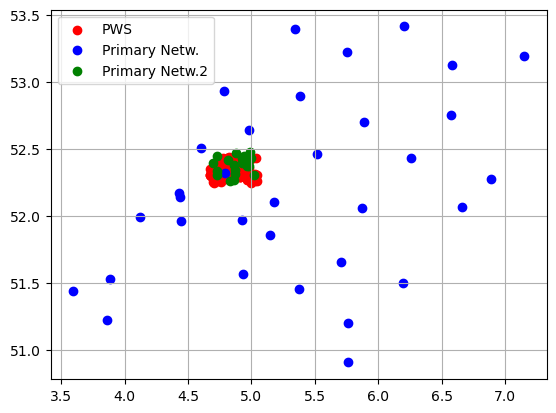

In [6]:
print('Plotting locations of all data')

pyqc.plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)

Plotting locations of data in and around Amsterdam


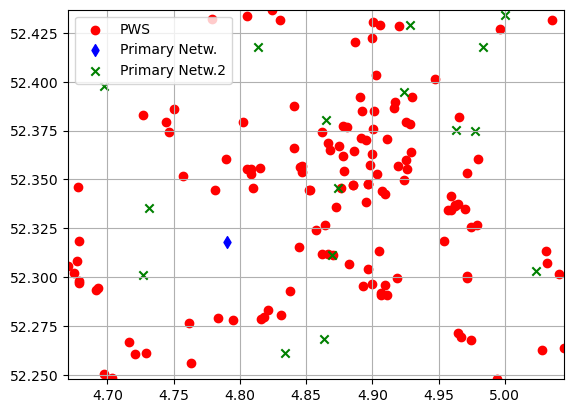

In [7]:
print('Plotting locations of data in and around Amsterdam')
pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)
    

## 3. First PWSpy-QC step: Indicator correlation based filter

The fist QC-filter of PWS-pyqc is based on indicator correlation patterns of the primary network (cf. [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)). First, the data of the primary network are converted to 1 and 0 based on a threshhold, in this case the 99%-percentile. All values above this percentile are 1, all below 0. This indicator correaltion of the primay stations has a spatial structure, i.e. the correlaiton decreases with increasing distance

Calculating indicator correlation


  0%|                                                   | 0/133 [00:00<?, ?it/s]/home/jose/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jose/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████| 133/133 [00:10<00:00, 13.02it/s]


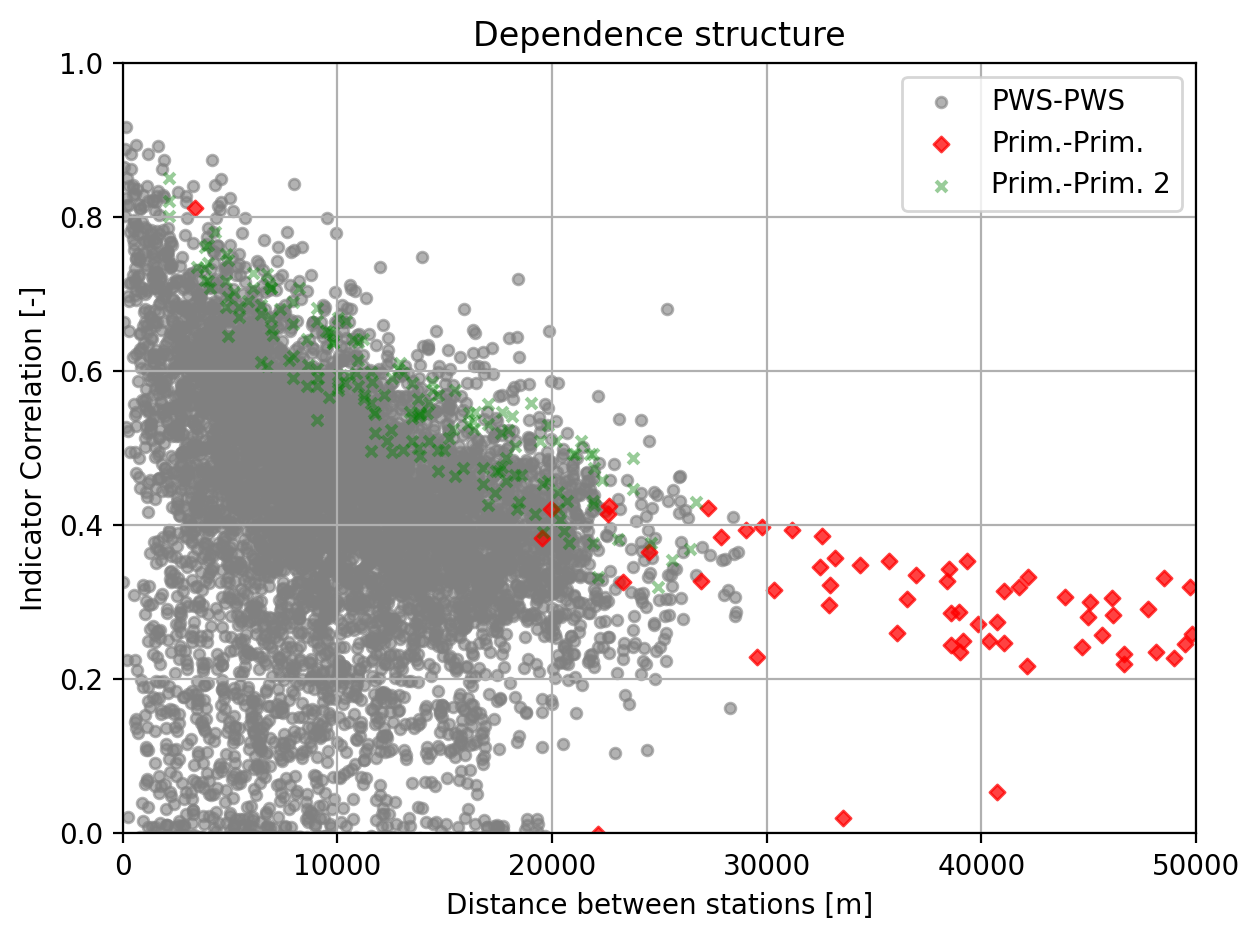

In [8]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')
dist_prim, corr_prim = pyqc.calc_indic_corr_all_stns(
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values, prob=0.99)

# calculate indicator correlation second primary network
dist_prim2, corr_prim2 = pyqc.calc_indic_corr_all_stns(
    coords_stns_xy=prim_coords_xy_2,
    pcp_vals=in_primary_pcp_2.values, prob=0.99)

# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = pyqc.calc_indic_corr_all_stns(
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2)

As can be seen in the plot above, the primary stations have a certain dependence sturcture over distance. Most of the PWS as well, but there are also some PWS which do not follow this structure. When the indicator corrleation of a PWS next to a primary station is low, then it is likley that the PWS data are faulty.The first QC-filer pf PWS-pyqc now removes all PWS which do not show indicaotr correlations similiar to that of the reference data (primay stations).

100%|█████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


Total Accepted 85 134


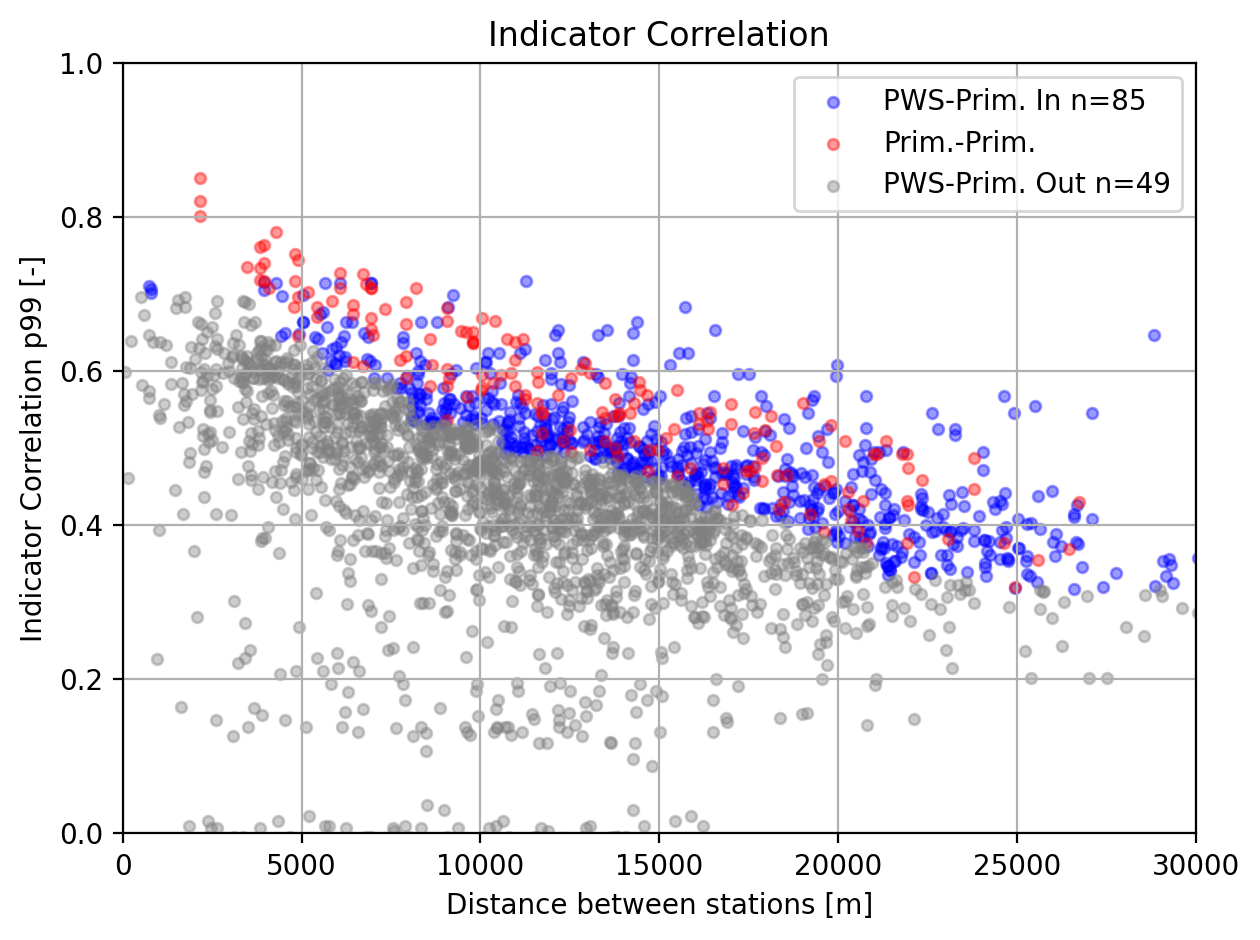

In [9]:
# apply indicator filter

stn_in = pyqc.indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy_2,
                 prc_dwd=in_primary_pcp_2,
                     prob=0.99, max_distance=50000,
                     min_req_ppt_vals=2*24*30, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)



In this case, 49 of 134 stations are removed because they deliver data that does not match what we would expect from the primary network.

In [10]:
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
pws_ids_accepted

Index(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams106', 'ams107', 'ams108', 'ams109', 'ams111',
       'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120', 'ams123',
       'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133', 'ams134'],
      dtype='object')

## Apply Bias Correction

The goal is to correct the PWS distribution function usind the distribution function of neighboring primary network stations. For more details see [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)


In [12]:
new_prc = pyqc.bias_correct(xy_net=pws_coords_xy,
                       prc_net=df_pws_pcp_hourly.values,
                       xy_prim=prim_coords_xy_2,
                       prc_prim=in_primary_pcp_2.values,
                           stn_in_bool=stn_in)

df_corrrected = pd.DataFrame(index=df_pws_pcp_hourly.index,
                              data=new_prc,
                              columns =df_pws_pcp_hourly.columns)

100%|████████████████████████████████████████| 134/134 [00:00<00:00, 268.12it/s]


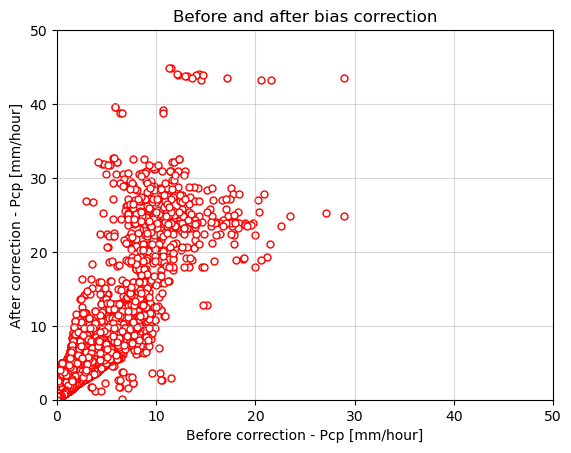

In [13]:
# plot results after bias correction
plt.figure(dpi=100)
plt.title('Before and after bias correction')
plt.scatter(
    df_pws_pcp_hourly.iloc[:, stn_in].values,
    df_corrrected.iloc[:, stn_in].values,
    edgecolor='r',
    facecolor='w',
    marker='o',
s=25)



plt.plot([0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        [0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        c='grey',
        linestyle='-.')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.xlabel('Before correction - Pcp [mm/hour]')
plt.ylabel('After correction - Pcp [mm/hour]')
plt.grid(alpha=0.5)     
        


### Interpolate rainfall map from filtered and bias corrected PWS for a timestep

In [14]:
# Set up the IDW interpolator
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3)

#Create coordinates and data for interpolating values for a given timestamp/index
lon_pws=df_pws_coords.loc[pws_ids_accepted]
lat_pws=df_pws_coords.loc[pws_ids_accepted]
pcp_all=df_corrrected.iloc[18210, stn_in].values

#Create indices for valid stations for the specific time step
idx=np.where(pcp_all>= 0)

R_grid = idw_interpolator(
    x=lon_pws.lon.values[idx], 
    y=lat_pws.lat.values[idx], 
    z=pcp_all[idx], 
    resolution=0.01,)

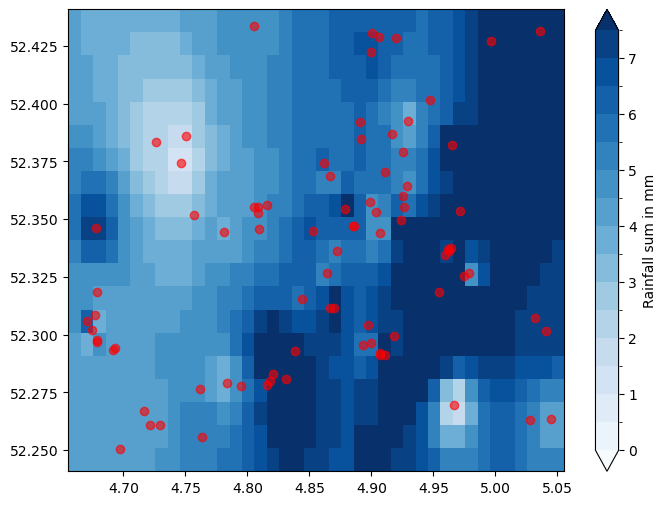

In [15]:
# Plot the interpolated map and the locations of the accepted PWS
bounds = np.arange(0, 8, 0.5)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='Blues',
    norm=norm,
)
plt.scatter(lon_pws.lon,lat_pws.lat, marker='o', color='r', alpha=.6)
fig.colorbar(pc, label='Rainfall sum in mm');
